---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

## Introduction
In this stage, I will be using supervising learning techniques for regressinon, binary classification and multi-class classification tasks. 
My goal is to be able to answer the following research questions:

1. Can we predict whether an individual has shopped online based on their demographic and financial information in the past year?
2. Can we predict one's online shopping expenditure based on their annual earnings and expenses?
3. Can we predict one's sex based on their demographics and financial information?
4. Can we predict one's education level based on demographic and financial information?
5. Can we predict one's income level based on demographic and financial information?


## Overview of Methods
In this stage, I will begin by doing feature selection, correlation tests for Regression and Chi Squared tests for the Classification sections. After that I will split the data into train and test portions with a 80:20 ratio. Then, I will be doing some resampling either using SMOTE or balancing class weights, and also model tuning with GridSearchCV to find the best model parameters.

For Regression, I will implement Lasso, Elastic Net, Random Forest Regressor, XGBoost, and Decision Tree Regressor. Their performances will be compared and evaluated on their RMSE, MAE and R-squared values.
For Binary and Multi-Class Classification, I will implement Logistic Regression, Random Forest Classifier, LinearSVC, Decision Tree Classifier, Gaussian Naive Bayes, K Nearest Neighbors Classifier, and XGBoost Classifier. For Binary, the model performances will be evaluated upon AUC, precision, recall, f-1, and accuracy scores. Multi-class classification models will be evaluated on everything bar AUC score.

## Code 


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import spearmanr, pearsonr
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Load dataset
df = pd.read_csv('../../data/processed-data/ces_clean_normalized.csv')

# Identify relevant columns
continuous_cols = ['total_expense', 'online_expense', 'total_income']
boxcox_continuous_cols = ['boxcox_total_expense', 'boxcox_online_expense', 'boxcox_total_income', 'age']
categorical_cols = ['is_asian', 'is_black', 'race_unknown', 'is_native_american', 'is_other_race',
                     'is_pacific_islander', 'is_white', 'full_time_1_yr',
                     'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr',
                     'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree',
                     'high_school_grad', 'some_college_no_degree', 'associates_degree',
                     'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed',
                     'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'income_category', 'bought_online']
combined_cols = continuous_cols + categorical_cols
boxcox_combined_cols = boxcox_continuous_cols + categorical_cols
target_cols = ['highest_ed_completed']


### Feature Selection

I wanted to first start off to do feature selection for the Regression section by using correlation-based feature selection. It involves identifying and removing highly correlated features in a dataset to reduce redundancy and potential multicollinearity. In the code below, the process starts by calculating the Pearson correlation matrix for the continuous features in the dataset. The matrix quantifies the linear relationships between pairs of features, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation). Next, a heatmap is used to visually inspect these correlations. Features with a correlation above a defined threshold (0.9) are considered highly correlated. To avoid multicollinearity, one feature from each highly correlated pair is removed. The remaining features, which have lower correlations with each other, are then selected for further analysis, ensuring a more stable and interpretable model. There was no pair of features that have a strong positive or negative correlation than obviously a feature with itself beside online_percentage and online_expense because the former is derived from the latter. Therefore, I do not need to eliminate anything based on correlation except I should only be using one of online_percentage and online_expense per time.  

In the Binary and Multiclass Classification sections, I will be conducting feature selection via Chi-Squared tests. They are used primarily for categorical features. It works by calculating the chi-square statistic and the associated p-value to measure the independence between the feature and the target. Features with low p-values (typically below a significance level of 0.05) are considered more strongly associated with the target variable and are selected.

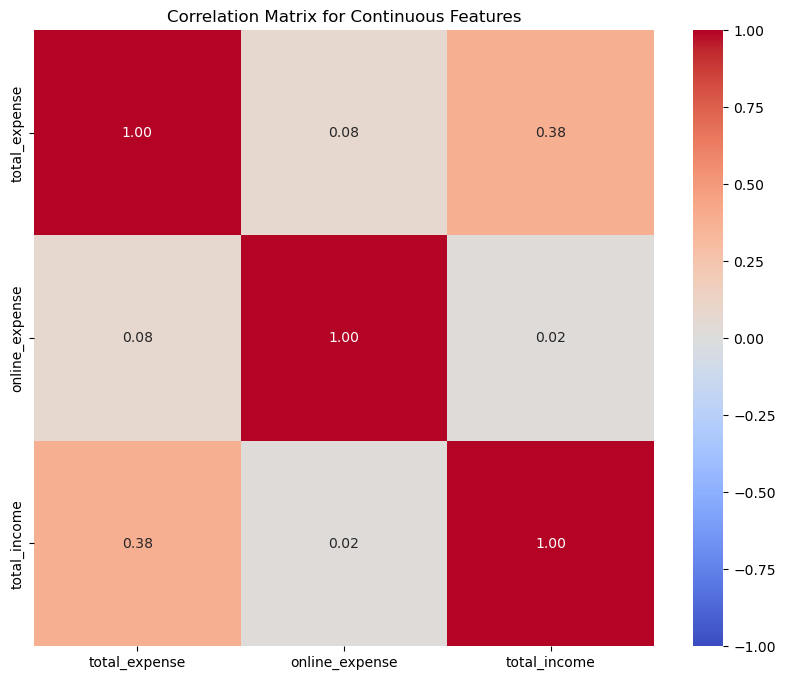

Selected Continuous Features after Correlation-Based Feature Selection:
['total_expense', 'online_expense', 'total_income']


In [28]:
# Select only the continuous columns
df_continuous = df[continuous_cols]

# Compute the correlation matrix
corr_matrix = df_continuous.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix for Continuous Features')
plt.show()

# Feature selection: remove highly correlated features (correlation > 0.9)
threshold = 0.9
# Find pairs of features with correlation greater than the threshold
high_corr_vars = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_vars.add(colname)

# Remove the highly correlated features
selected_continuous_cols = [col for col in continuous_cols if col not in high_corr_vars]


print("Selected Continuous Features after Correlation-Based Feature Selection:")
print(selected_continuous_cols)


## Regression Section ###

In this section, I will be employing 5 models for regression: Lasso, Elastic Net, Random Forest Regressor, XGBoost and Decision Tree Regressor. Please continue reading for a brief overview of the regression ML models.

### 1. **Lasso Regression**

Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression method that uses L1 regularization to discourage large coefficients. @noauthor_types_nodate

**Inputs:**
- Numerical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameter:**
- **Alpha:** Controls the strength of the L1 regularization, balancing model complexity and prediction accuracy.


### 2. **ElasticNet Regression**
ElasticNet is a linear regression model that combines the penalties of Lasso (L1) and Ridge (L2) regularization. It is particularly useful when there are multiple correlated features in the dataset, as it can both shrink coefficients and perform feature selection. @noauthor_types_nodate

**Inputs:**
- Numerical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **Alpha:** Controls the overall strength of regularization.
- **L1 Ratio:** Controls the balance between L1 and L2 regularization.

### 3. **Random Forest Regressor**
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through majority vote to improve accuracy and control overfitting. @noauthor_types_nodate

**Inputs:**
- Numerical or categorical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **n_estimators:** Number of trees in the forest.
- **max_depth:** Maximum depth of each tree.
- **min_samples_split:** Minimum number of samples required to split a node.
- **min_samples_leaf:** Minimum number of samples required to be at a leaf node.

### 4. **XGBoost Regressor**
XGBoost is a powerful ensemble learning method that combines multiple decision trees to make predictions. It works iteratively, with each tree correcting the errors of the previous ones. 

**Inputs:**
- Numerical or categorical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **Learning Rate:** Controls the step size at each iteration.
- **Maximum Depth:** Limits the depth of individual trees.
- **Number of Estimators:** Determines the number of trees in the ensemble.
- **Subsample:** Fraction of samples used for each tree.
- **Colsample_bytree:** Fraction of features used for each tree.

### 5. **Decision Tree Regressor**
**Decision Tree Regressor** is a simple and effective model that makes decisions based on a series of if-else conditions. It recursively divides the data into subsets, creating a tree-like structure. @noauthor_types_nodate

**Inputs:**
- Numerical or categorical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **Maximum Depth:** Controls the maximum depth of the tree.
- **Minimum Samples Split:** Minimum number of samples required to split a node.
- **Minimum Samples Leaf:** Minimum number of samples required to be at a leaf node.
- **Criterion:** The function to measure the quality of a split (e.g., MSE, MAE).


@noauthor_chat-gpt_nodate to help me figure out how to implement GridSearchCV

### Regression problem: Can we predict one's online shopping expenditure based on their annual earnings and expenses?

Model: Lasso
Best Parameters: {'alpha': 10, 'max_iter': 1000}
RMSE: 7750.030
MAE: 4035.918
R-squared: -3.332



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


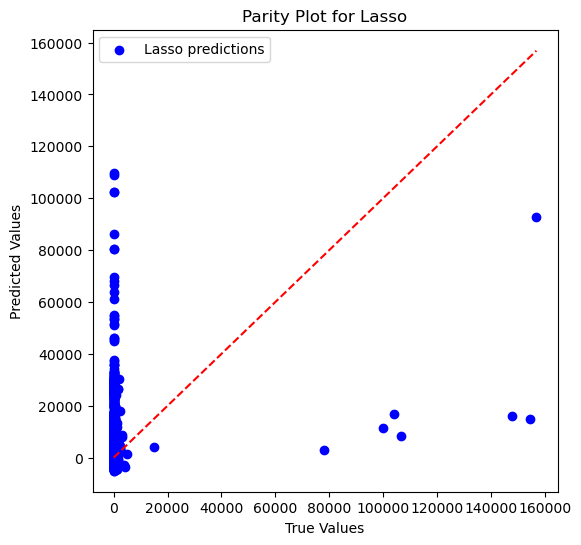

Model: ElasticNet
Best Parameters: {'alpha': 1, 'l1_ratio': 0.1, 'max_iter': 1000}
RMSE: 6196.022
MAE: 3435.815
R-squared: -1.769



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


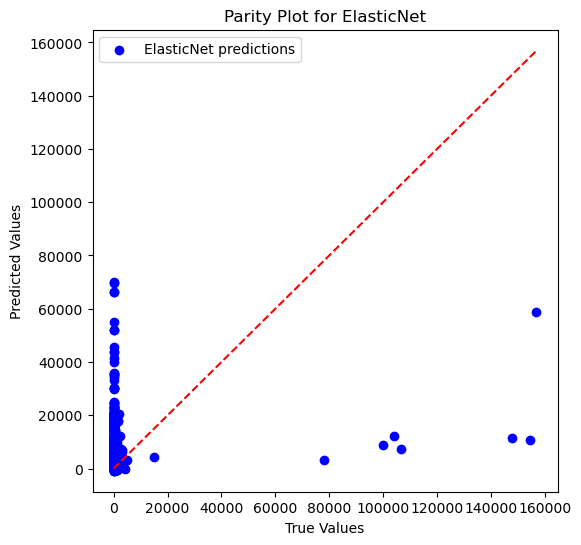

Model: RandomForestRegressor
Best Parameters: {'max_depth': 30, 'n_estimators': 45}
RMSE: 2083.498
MAE: 76.155
R-squared: 0.687



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


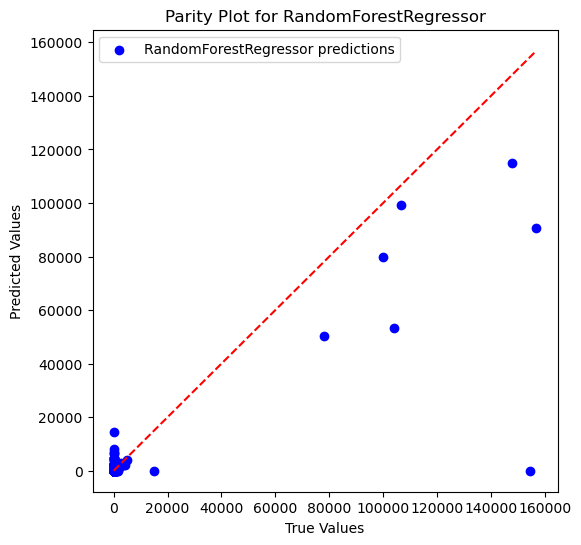

Model: XGBoost
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
RMSE: 4501.885
MAE: 3090.374
R-squared: -0.462



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


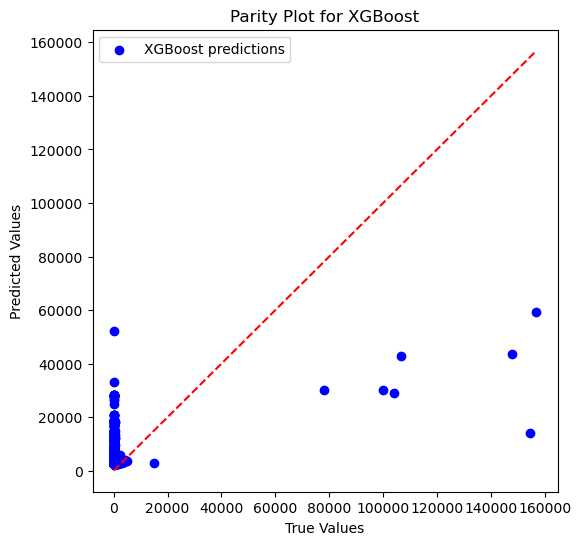

Model: DecisionTreeRegressor
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
RMSE: 1754.225
MAE: 27.525
R-squared: 0.778



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


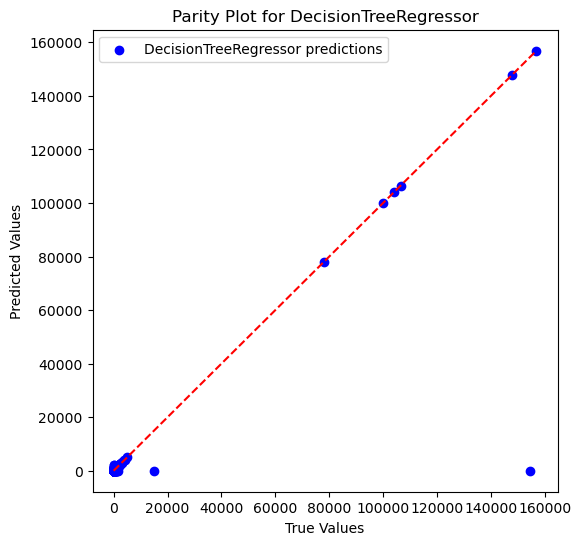

In [71]:
# Research Question: Can we predict one's online shopping expenditure based on their annual earnings and expenses?
X_regression = df_continuous.drop(columns='online_expense')
y_regression = df_continuous['online_expense']

# Scale the features
scaler = StandardScaler()
X_regression_scaled = scaler.fit_transform(X_regression)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_regression_scaled, y_regression, test_size=0.2, random_state=42)

# Compute sample weights due to class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Model Selection and Training
models = {
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42)
}

# Model Tuning with GridSearchCV
for name, model in models.items():
    # Define the parameter grid for each model
    param_grid = {
        'Lasso': {'alpha': [0.01, 0.1, 0.5, 1, 10], 'max_iter': [1000]},
        'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1], 'l1_ratio': [0.1, 0.5, 0.9], 'max_iter': [1000]},
        'RandomForestRegressor': {'n_estimators': [5, 15, 25, 35, 45], 'max_depth': [10, 20, 30, None]},
        'XGBoost': {
            'n_estimators': [50, 100, 150, 200], 
            'learning_rate': [0.01, 0.05, 0.1], 
            'max_depth': [3, 5, 7], 
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'DecisionTreeRegressor': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5]}
    }

    # Perform GridSearchCV to find the best parameter combination
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate and print performance metrics
    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"R-squared: {r2_score(y_test, y_pred):.3f}\n")

    # Plotting predictions vs actual for comparison (parity plot)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, color='blue', label=f'{name} predictions')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Parity Plot for {name}")
    plt.legend()
    plt.show()


### **Table of Results**

| Model | RMSE | MAE | R-squared |
|---|---|---|---|
| Lasso | 7750.03 | 4035.92 | -3.332 |
| ElasticNet | 6196.02 | 3435.82 | -1.769 |
| RandomForestRegressor | 2083.50 | 76.16 | 0.687 |
| XGBoost | 4501.89 | 3090.37 | -0.462 |
| DecisionTreeRegressor | 1754.23 | 27.53 | 0.778 |

### **Model Results Interpretation**

#### **Lasso Regression**
Lasso performed poorly, with a very high RMSE and negative R-squared, indicating the model failed to explain the variance in online shopping expenditure.


#### **ElasticNet Regression**
ElasticNet outperformed Lasso slightly, but the negative R-squared suggests that it struggled to generalize, likely due to the complexity of the relationships in the data.

#### **RandomForestRegressor**
Random Forest was one of the best performers, achieving a relatively low RMSE and an R-squared value of 0.687, indicating that it explained approximately 68.7% of the variance in online shopping expenditure.

#### **XGBoost**
XGBoost performed moderately but fell short compared to Random Forest and Decision Tree. The negative R-squared highlights its difficulty in modeling this dataset effectively under the given parameters.

#### **DecisionTreeRegressor**
Decision Tree was the best performer, achieving the lowest RMSE and MAE and the highest R-squared (0.778), explaining 77.8% of the variance in online shopping expenditure.



#### Explanation of metrics
- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values. A smaller RMSE indicates better model accuracy.
- **MAE (Mean Absolute Error)**: Similar to RMSE but without the squared term. It gives a more direct measure of prediction accuracy by averaging absolute differences.
- **R-squared**: Indicates the proportion of variance in the target variable explained by the model. An R-squared of 1 means perfect predictions, and 0 means no explanatory power. Negative values suggest poor predictive power.

The parity plots show how well the predicted values match the actual values, with the ideal result being a 45-degree line indicating perfect predictions. For Lasso, ElasticNet, and XGBoost, the line does not fit the distribution of points. For Random Forest and Decision Tree, the points are more aligned.

### Key Insight from Analysis

Using Decision Tree Regressor, we can effectively address our research question, "Can we predict one's online shopping expenditure based on their annual earnings and expenses?".


---

## Binary Classification Section

In this section, I will be employing 7 models for binary classification: Logistic Regression, Random Forest (Random Forest Classifier), Linear Support Vector Classification (LinearSVC), Decision Tree (Decision Tree Classifier), Naive Bayes (GaussianNB), K Nearest Neighbors (KNN), and XGBoost (XGBoost Classifier). Please continue reading for a brief overview of these classification ML models. Please note, that these models are capable of doing multi-class classifiation, too, so I will use them in the Multi-class Classification Section.

### Logistic Regression

Logistic regression models the probability of a binary outcome. It uses a logistic function to model a the probability of a data point belonging to one of two classes, learning the coefficients of the linear combination during training. @noauthor_top_2024

**Inputs:**
* Numerical or categorical features

**Outputs:**
* Probability of belonging to a specific class (0 or 1)

**Key Hyperparameter:**
* **Regularization strength (C):** Controls the trade-off between model complexity and overfitting.

### Random Forest Classifier

Random Forest is an ensemble method that combines multiple decision trees. Each tree is trained on a random subset of the data and features. The final prediction is made by averaging the predictions of all trees. This ensemble approach helps reduce overfitting and improve generalization. @noauthor_top_2024

**Inputs:**
* Numerical or categorical features

**Outputs:**
* Predicted class label

**Key Hyperparameters:**
* **n_estimators:** Number of trees in the forest.
* **max_depth:** Maximum depth of each tree.
* **min_samples_split:** Minimum number of samples required to split a node.
* **min_samples_leaf:** Minimum number of samples required to be at a leaf node.

### LinearSVC

LinearSVC finds the optimal hyperplane that separates the data into two classes. It maximizes the margin between the classes while minimizing classification errors. The model learns the coefficients of the hyperplane during training. @noauthor_top_2024

**Inputs:**
* Numerical features

**Outputs:**
* Predicted class label

**Key Hyperparameter:**
* **C:** Regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors.

### Decision Tree Classifier

A decision tree classifier creates a tree-like model of decisions and their possible consequences. Each node in the tree represents a decision based on a feature, and each branch represents a possible outcome. The leaves of the tree represent the predicted class. @noauthor_top_2024

**Inputs:**
* Numerical or categorical features

**Outputs:**
* Predicted class label

**Key Hyperparameters:**
* **max_depth:** Maximum depth of the tree.
* **min_samples_split:** Minimum number of samples required to split a node.
* **min_samples_leaf:** Minimum number of samples required to be at a leaf node.
* **criterion:** Function to measure the quality of a split (e.g., Gini impurity, entropy).

### Naive Bayes (GaussianNB)

Naive Bayes assumes that features are independent given the class label. It calculates the probability of a class given the feature values using Bayes' theorem. For numerical features, it assumes a Gaussian distribution. @noauthor_top_2024

**Inputs:**
* Numerical features

**Outputs:**
* Predicted class label

**Key Hyperparameter:**
* **var_smoothing:** A small value added to the variance to avoid division by zero.

### K-Nearest Neighbors (KNN)

KNN classifies a data point based on the majority class of its k nearest neighbors. The distance between data points is calculated using a distance metric like Euclidean distance. The model simply stores the training data and classifies new data points by finding their nearest neighbors. @noauthor_top_2024

**Inputs:**
* Numerical features

**Outputs:**
* Predicted class label

**Key Hyperparameter:**
* **n_neighbors:** Number of neighbors to consider.

### XGBoost Classifier

XGBoost is a powerful ensemble learning method that combines multiple decision trees to make accurate predictions. @noauthor_top_2024

How it works:
1. **Base Model:** An initial simple model (e.g., a decision tree) is trained on the entire dataset.
2. **Residual Learning:** The errors or residuals from the base model are calculated.
3. **Subsequent Models:** New models are trained to predict these residuals, focusing on the parts of the data where the base model underperformed.
4. **Ensemble:** The predictions from all the models are combined to form the final prediction.

**Inputs:**

* Numerical or categorical features
* Target variable (class labels)

**Outputs:**

* Predicted class label

**Key Hyperparameters:**

* **n_estimators:** Number of trees in the ensemble.
* **max_depth:** Maximum depth of each tree.
* **learning_rate:** Step size at each iteration.
* **subsample:** Fraction of samples used for training each tree.
* **colsample_bytree:** Fraction of features used for each tree.
* **gamma:** Minimum loss reduction required to make a split.
* **lambda:** L2 regularization term.
* **alpha:** L1 regularization term.


**Note on Box-Cox Transformed features:** While the Box-Cox transformation is typically used for continuous response variables in linear regression, it can indirectly benefit logistic regression by improving the quality of the underlying data. By transforming skewed or non-normal features, Box-Cox can make the data more suitable for modeling, which can in turn improve the performance of logistic regression. Additionally, a well-distributed dataset can help the optimization algorithms used in logistic regression converge more efficiently.
While Box-Cox transformation is often used to improve the performance of linear regression models, it may not be as beneficial for the following models:

For Random Forest Classifier, Decision Tree Classifier, and K-Nearest Neighbors: These models are non-parametric and can handle non-linear relationships and non-normal distributions. They are less sensitive to the specific distribution of the input features. Therefore, applying a Box-Cox transformation might not have a significant impact on their performance.

For Linear Support Vector Classification (LinearSVC): Similar to logistic regression, LinearSVC is a linear model. However, the focus is on finding the optimal hyperplane to separate the classes. While Box-Cox can improve the distribution of features, it may not directly impact the decision boundary.

For Naive Bayes (GaussianNB): Naive Bayes assumes that features are independent given the class label. While Box-Cox can improve the normality of features, it may not significantly impact the independence assumption. Moreover, Naive Bayes is often robust to non-normality, especially with larger datasets.

@noauthor_chat-gpt_nodate to effectively selecting and printing features and p-values

### Binary Classifcation Problem 1: Can we predict whether an individual has shopped online based on demographic, financial and shopping preference variables?

In [49]:
# Research Question: Predict whether the individual has shopped online (binary classification)

#Data cleaning for chi squared test
income_dict = {'Low': 0, 'Middle': 1, 'High': 2}

# For Logistic Regression (Box-Cox-transformed data)
boxcox_binary_class_df = df[boxcox_combined_cols]
boxcox_binary_class_df['income_category'] = boxcox_binary_class_df['income_category'].replace(income_dict)
X_binary_boxcox = boxcox_binary_class_df.drop(columns='bought_online')
y_binary_boxcox = boxcox_binary_class_df['bought_online']

# For all other models
binary_class_df = df[combined_cols]
binary_class_df['income_category'] = binary_class_df['income_category'].replace(income_dict)
X_binary = binary_class_df.drop(columns='bought_online')
y_binary = binary_class_df['bought_online']

# Feature Selection: Chi-square test for X_binary and y_binary
print("Chi-Square Test P-values for X_binary:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected = chi2_selector.fit_transform(X_binary, y_binary)
p_values = chi2_selector.pvalues_

for feature, p_value in zip(X_binary.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_binary.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_binary: {selected_features}")

# Feature Selection: Chi-square test for X_binary_boxcox and y_binary_boxcox
print("\nChi-Square Test P-values for X_binary_boxcox:")
chi2_selector_boxcox = SelectKBest(chi2, k='all')
X_selected_boxcox = chi2_selector_boxcox.fit_transform(X_binary_boxcox, y_binary_boxcox)
p_values_boxcox = chi2_selector_boxcox.pvalues_

for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox):
    print(f"{feature}: {p_value}")

selected_features_boxcox = [
    feature for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox) if p_value < 0.05
]
print(f"Selected features after Chi-square test for X_binary_boxcox: {selected_features_boxcox}")


Chi-Square Test P-values for X_binary:
total_expense: 0.0
online_expense: 0.0
total_income: 0.0
is_asian: 0.15217685907720935
is_black: 0.00010982947325401559
race_unknown: 0.8565030475655357
is_native_american: 0.9530915532317705
is_other_race: 0.017870176187389987
is_pacific_islander: 0.6725904811311745
is_white: 8.001865448028292e-16
full_time_1_yr: 0.02002474394092006
part_time_1_yr: 0.14289030645293085
full_time_part_yr: 0.03519145383551706
part_time_part_yr: 0.1321589921988693
no_school_completed: 0.009528197065347776
grades_1-8_completed: 2.4342758686852012e-06
high_school_no_degree: 3.122036264295844e-13
high_school_grad: 1.3594354087167185e-16
some_college_no_degree: 0.0012611977680571321
associates_degree: 0.021838468961397538
bachelors_degree: 9.741894922105698e-20
graduate_degree: 6.367416256986332e-19
is_married: 0.0009441136963829701
is_widowed: 5.249195925305053e-09
is_divorced: 0.0031962842508815727
is_separated: 0.07999737450506256
is_single: 0.5934761274035121
is_fema

/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/931466289.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  boxcox_binary_class_df['income_category'] = boxcox_binary_class_df['income_category'].replace(income_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/931466289.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxcox_binary_class_df['income_category'] = boxcox_binary_class_df['income_category'].replace(income_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykern

Selected features after Chi-square test for X_binary: ['total_expense', 'online_expense', 'total_income', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'full_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'income_category']

Selected features after Chi-square test for X_binary_boxcox: ['boxcox_total_expense', 'boxcox_online_expense', 'boxcox_total_income', 'age', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'full_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'income_category']

@noauthor_chat-gpt_nodate to understand Logistic Regression has predict_proba method


Model: LogisticRegression
Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852


Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 15}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852


Model: LinearSVC
Best Parameters: {'C': 10}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7290
           1       1.00      0.88      0.94       

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:45:05] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:45:05] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:45:05] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho


Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



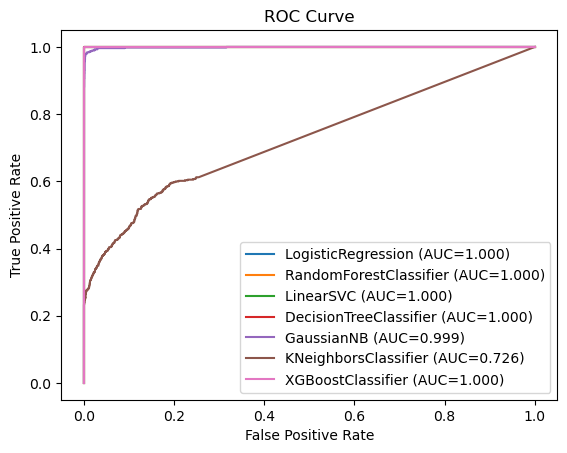

In [50]:
# Reassign datasets with selected features
X_binary_selected = X_binary[selected_features]
X_binary_boxcox_selected = X_binary_boxcox[selected_features_boxcox]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_binary_selected, y_binary, test_size=0.2, random_state=42)
# Compute sample weights due to class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Split the Box-Cox transformed data for Logistic Regression
X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(X_binary_boxcox_selected, y_binary_boxcox, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling the minority class (only for Logistic Regression)
smote_boxcox = SMOTE(random_state=42)
X_train_resampled_boxcox, y_train_resampled_boxcox = smote_boxcox.fit_resample(X_train_boxcox, y_train_boxcox)


# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    # Define parameter grid for GridSearchCV
    param_grid = {
        'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20, 30, 50]},
        'RandomForestClassifier': {'n_estimators': [5, 15, 25, 35, 45, 55, 75, 105], 'max_depth': [10, 20, 30, None]},
        'LinearSVC': {'C': [0.01, 0.1, 1, 10, 100]},
        'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
        'GaussianNB': {},  # No hyperparameters for GaussianNB
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGBoostClassifier': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    }

    # Adjust training data for specific models
    if name == 'LogisticRegression':
        X_train_model = X_train_resampled_boxcox
        y_train_model = y_train_resampled_boxcox
        X_test_model = X_test_boxcox
        y_test_model = y_test_boxcox
    elif name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    # GridSearchCV to find the best model
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='roc_auc')
    if  name in ['RandomForestClassifier', 'DecisionTreeClassifier', 'XGBoostClassifier']:
        grid_search.fit(X_train_model, y_train_model, sample_weight = sample_weights)
    else:
        grid_search.fit(X_train_model, y_train_model)
        

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)

    # Print classification report
    print(f"\nModel: {name}")
    print(f"Best Parameters: {grid_search.best_params_ if param_grid[name] else 'Default Parameters'}")
    print(classification_report(y_test_model, y_pred))

    # Plot ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_model)[:, 1]
    else:  # For models like LinearSVC without `predict_proba`
        y_prob = best_model.decision_function(X_test_model)

    fpr, tpr, _ = roc_curve(y_test_model, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test_model, y_prob):.3f})')

# Show ROC plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Summary of Results for Binary Classification

#### Logistic Regression:
- **AUC**: 1.00
- **Performance**: Perfect classification with a 100% precision, recall, and F1-score for both classes. The model demonstrates perfect generalization on the test data.

#### Random Forest Classifier:
- **AUC**: 1.00
- **Performance**: Identical to Logistic Regression, with perfect precision, recall, and F1-score for both classes. The model is highly effective at distinguishing between online and in-store shoppers.

#### LinearSVC:
- **AUC**: 1.00
- **Performance**: Overall accuracy is 99%, with a slight drop in recall (88%) for the minority class (online shoppers). This indicates the model struggles to identify all online shoppers compared to other models.

#### Decision Tree Classifier:
- **AUC**: 1.00
- **Performance**: Perfect classification metrics, matching Logistic Regression and Random Forest. The model is highly interpretable, which is an added advantage for decision-making.

#### Gaussian Naive Bayes:
- **AUC**: 0.999
- **Performance**: Accuracy and precision for the majority class are near-perfect, but recall and precision for the minority class is 96% and 97%, respectively. This suggests some difficulty in capturing all online shoppers.

#### K-Nearest Neighbors (KNN):
- **AUC**: 0.726
- **Performance**: Significantly lower performance than other models though accuracy = 0.94. The recall for online shoppers is only 26%, leading to poor F1-score of 0.39 for that class. This model struggles to differentiate between the classes effectively.

#### XGBoost Classifier

- **AUC**: 0.999
- **Performance:** Perfect classification metrics across the board. XGBoost efficiently learned complex patterns with a modest depth, confirming its robustness and adaptability to various data distributions.


### Insights Gained

1. **Impactful Factors:** total income, total expense, online expenses, age, education level, race, earning type and marital status all play a role in determining whether or not a person has purchased something online. Sex does not seem to play a role.

2. **Class Imbalance Management**: Models like Logistic Regression and Random Forest can handle imbalanced data effectively, likely aided by resampling and hyperparameter tuning.

3. **Feature Importance**: Tree-based models like Random Forest and Decision Tree provide insights into feature importance, allowing us to identify key predictors for online shopping behavior.

4. **Scalability**: Logistic Regression and Decision Tree are computationally efficient and scalable to larger datasets, making them more practical for real-world applications compared to resource-intensive models like KNN.

5. **Interpretability**: Decision Tree is the most interpretable model, which is valuable for explaining predictions to stakeholders and identifying actionable insights.

6. **Limitations of Non-linear Models**: Despite being theoretically powerful, models like KNN and LinearSVC fail to outperform simpler models in this case. This highlights the importance of model selection based on the dataset's characteristics.

### Conclusion
From this analysis, we can confidently predict whether an individual has shopped online based on the dataset using demographic, and financial data. The results suggest that the dataset is highly structured, with features that strongly differentiate between the two classes. Logistic Regression, Random Forest, Decision Tree, and XGBoost are all excellent choices, with XGBoost offering the best combination of robustness, flexibility and generalizability. GaussianNB and LinearSVC also provide competitive performance, though they require careful handling of class imbalance. KNN, on the other hand, is unsuitable for this problem.

---

### Binary Classifcation Problem 2: Can we predict an individual's sex based on demographic, financial and shopping preference variables?

In [51]:
# Research Question: Can we predict one's sex based on their demographics, financial, and online shopping information? (binary classification)
# For RandomorestClassifier
binary_class_df = df[combined_cols]
binary_class_df['income_category'] = binary_class_df['income_category'].replace(income_dict)
X_binary2 = binary_class_df.drop(columns=['is_male', 'is_female'])
y_binary2 = binary_class_df['is_female']

# For Logistic Regression (Box-Cox-transformed data)
boxcox_binary_class_df = df[boxcox_combined_cols]
boxcox_binary_class_df['income_category'] = boxcox_binary_class_df['income_category'].replace(income_dict)
X_binary_boxcox = boxcox_binary_class_df.drop(columns=['is_male', 'is_female'])
y_binary_boxcox = boxcox_binary_class_df['is_female']

# Feature Selection: Chi-square test for X_binary2 and y_binary2
print("Chi-Square Test P-values for X_binary2:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected = chi2_selector.fit_transform(X_binary2, y_binary2)
p_values = chi2_selector.pvalues_

for feature, p_value in zip(X_binary2.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_binary2.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_binary2: {selected_features}")

# Feature Selection: Chi-square test for X_binary_boxcox and y_binary_boxcox (Logistic Regression)
print("\nChi-Square Test P-values for X_binary_boxcox:")
chi2_selector_boxcox = SelectKBest(chi2, k='all')
X_selected_boxcox = chi2_selector_boxcox.fit_transform(X_binary_boxcox, y_binary_boxcox)
p_values_boxcox = chi2_selector_boxcox.pvalues_

for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox):
    print(f"{feature}: {p_value}")

selected_features_boxcox = [
    feature for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox) if p_value < 0.05
]
print(f"Selected features after Chi-square test for X_binary_boxcox: {selected_features_boxcox}")


Chi-Square Test P-values for X_binary2:
total_expense: 0.0
online_expense: 0.0
total_income: 0.0
is_asian: 0.9252760002939772
is_black: 0.000602041688322881
race_unknown: 0.9799163104810702
is_native_american: 0.9864661620641817
is_other_race: 0.26684487185243716
is_pacific_islander: 0.6707534546985924
is_white: 1.525997648409876e-05
full_time_1_yr: 7.68707920365536e-56
part_time_1_yr: 1.5321350474188765e-23
full_time_part_yr: 0.0040576724745267105
part_time_part_yr: 4.650379050519512e-11
no_school_completed: 0.6706190207445876
grades_1-8_completed: 0.5084663266156371
high_school_no_degree: 0.00334200198814014
high_school_grad: 8.143159091514547e-07
some_college_no_degree: 0.3889907240314002
associates_degree: 2.8731267399412588e-06
bachelors_degree: 0.0007346650531785444
graduate_degree: 1.949146727486516e-07
is_married: 4.302997819087806e-06
is_widowed: 1.9519462374024126e-111
is_divorced: 8.136950833854062e-23
is_separated: 0.0002612546285133314
is_single: 4.938105362010431e-19
inco

/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/381760894.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  binary_class_df['income_category'] = binary_class_df['income_category'].replace(income_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/381760894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_class_df['income_category'] = binary_class_df['income_category'].replace(income_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/381760894.py:10: Fu

Selected features after Chi-square test for X_binary2: ['total_expense', 'online_expense', 'total_income', 'is_black', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'high_school_no_degree', 'high_school_grad', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'income_category']


Selected features after Chi-square test for X_binary_boxcox: ['boxcox_total_income', 'age', 'is_black', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'high_school_no_degree', 'high_school_grad', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'income_category']


Model: LogisticRegression
Best Parameters: {'C': 30}
              precision    recall  f1-score   support

           0       0.54      0.66      0.59      3726
           1       0.61      0.48      0.54      4126

    accuracy                           0.57      7852
   macro avg       0.57      0.57      0.57      7852
weighted avg       0.58      0.57      0.56      7852


Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 105}
              precision    recall  f1-score   support

           0       0.55      0.68      0.60      3726
           1       0.63      0.50      0.55      4126

    accuracy                           0.58      7852
   macro avg       0.59      0.59      0.58      7852
weighted avg       0.59      0.58      0.58      7852


Model: LinearSVC
Best Parameters: {'C': 10}
              precision    recall  f1-score   support

           0       0.54      0.60      0.57      3726
           1       0.60      0.54      0.57      41

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:55:57] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:55:57] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:55:57] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho


Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.55      0.65      0.60      3726
           1       0.62      0.51      0.56      4126

    accuracy                           0.58      7852
   macro avg       0.58      0.58      0.58      7852
weighted avg       0.59      0.58      0.58      7852



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:56:15] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


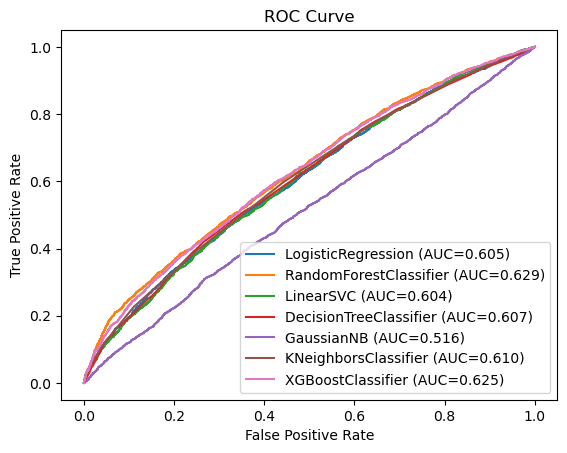

In [52]:
# Reassign datasets with selected features
X_binary_selected = X_binary2[selected_features]
X_binary_boxcox_selected = X_binary_boxcox[selected_features_boxcox]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_binary_selected, y_binary2, test_size=0.2, random_state=42
)
# Compute sample weights due to class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split the Box-Cox transformed data for Logistic Regression
X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(
    X_binary_boxcox_selected, y_binary_boxcox, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class (only for Logistic Regression)
smote_boxcox = SMOTE(random_state=42)
X_train_resampled_boxcox, y_train_resampled_boxcox = smote_boxcox.fit_resample(X_train_boxcox, y_train_boxcox)


# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


for name, model in models.items():
    # Define parameter grid for GridSearchCV
    param_grid = {
        'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20, 30, 50]},
        'RandomForestClassifier': {'n_estimators': [5, 15, 25, 35, 45, 55, 75, 105], 'max_depth': [10, 20, 30, None]},
        'LinearSVC': {'C': [0.01, 0.1, 1, 10, 100]},
        'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
        'GaussianNB': {},  # No hyperparameters for GaussianNB
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGBoostClassifier': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    }

    # Adjust training data for specific models
    if name == 'LogisticRegression':
        X_train_model = X_train_resampled_boxcox
        y_train_model = y_train_resampled_boxcox
        X_test_model = X_test_boxcox
        y_test_model = y_test_boxcox
    elif name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    # GridSearchCV to find the best model
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='roc_auc')
    if  name in ['RandomForestClassifier', 'DecisionTreeClassifier', 'XGBoostClassifier']:
        grid_search.fit(X_train_model, y_train_model, sample_weight = sample_weights)
    else:
        grid_search.fit(X_train_model, y_train_model)
        

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)

    # Print classification report
    print(f"\nModel: {name}")
    print(f"Best Parameters: {grid_search.best_params_ if param_grid[name] else 'Default Parameters'}")
    print(classification_report(y_test_model, y_pred))

    # Plot ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_model)[:, 1]
    else:  # For models like LinearSVC without predict_proba
        y_prob = best_model.decision_function(X_test_model)

    fpr, tpr, _ = roc_curve(y_test_model, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test_model, y_prob):.3f})')

# Show ROC plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### **Summary of Each Model's Performance**

1. **Logistic Regression**:
   - **AUC**: 0.605
   - **Performance**:  
     - Accuracy: 57%.  
     - Precision, recall, and F1-scores for both classes are around 0.54–0.61, indicating a modest ability to distinguish between the two sexes.  
     - The model struggles to balance recall and precision for both classes.
     - The relatively low scores suggest that the relationship between features and the target is not entirely linear or that additional preprocessing is needed.

2. **Random Forest Classifier**:
   - **AUC**: 0.629
   - **Performance**:  
     - Accuracy: 58%
     - Like precision, recall, and F1-scores for both classes are around 0.55–0.61, indicating a modest ability to distinguish between the two sexes.
     - The model struggles to balance recall and precision for both classes.

3. **LinearSVC**:
   - **AUC**: 0.604
   - **Performance**:  
     - Accuracy: 57%
     - Like precision, recall, and F1-scores for both classes are around 0.54–0.60, indicating a modest ability to distinguish between the two sexes.
     - The model struggles to balance recall and precision for both classes.
  
4. **Decision Tree Classifier**:
   - **AUC**: 0.607
   - **Performance**:  
     - Accuracy: 57%
     - Like precision, recall, and F1-scores for both classes are around 0.54–0.61, indicating a modest ability to distinguish between the two sexes.
     - The model struggles to balance recall and precision for both classes.

5. **Gaussian Naive Bayes**:
   - **AUC**: 0.516
   - **Performance**:  
     - Accuracy: 51%
     - Like precision, recall, and F1-scores for both classes are around 0.49–0.56, indicating a modest ability to distinguish between the two sexes.
     - The model struggles to balance recall and precision for both classes.
     - Worst performing model across the board.
  
6. **K-Nearest Neighbors (KNN)**:
   - **AUC**: 0.610
   - **Performance**:  
     - Accuracy: 58%
     - Like precision, recall, and F1-scores for both classes are around 0.56–0.60, indicating a modest ability to distinguish between the two sexes.
     - The model struggles to balance recall and precision for both classes.
  

7. **XGBoost Classifier**:
   - **AUC**: 0.625
   - **Performance**:  
     - Accuracy: 58%
     - Like precision, recall, and F1-scores for both classes are around 0.56–0.61, indicating a modest ability to distinguish between the two sexes.
     - The model struggles to balance recall and precision for both classes.


### **Insights Gained**

1. **Limited Predictive Power**:  No model exhibits a strong ability to differentiate between the sexes based on the provided demographic, financial, and online shopping features.

2. **Feature Importance**: The modest AUC scores indicate that the financial factors alone may not be sufficient to predict sex accurately. The consistent struggle across models to balance precision and recall for both classes suggests either insufficient predictive power of the features, or data preprocessing or feature engineering might be required to extract more meaningful signals.
   
3. **Model Comparisons**: Random Forest and XGBoost performed the best among the models, likely due to their ability to handle non-linear relationships and feature interactions. Linear models and Naive Bayes struggled, indicating that the relationships between features and the target are complex and non-linear.


### **Recommendation**
From a business perspective, demographic, financial, and online shopping preference factors alone may not be sufficient to segment customers or target campaigns based on sex. Additional data sources or segmentation criteria may be required to achieve meaningful insights.

---

### Binary Classifcation Problem 3: Can we predict whether an individual has shopped online based on race, education and their marital status?

In [53]:
# Research Question: Can we predict whether one has purchased online based on race, education, marital status?


binary3_df = df[['race', 'highest_ed_completed', 'marital_status', 'bought_online']]

# Convert strings to numerical values for Chi square test
race_dict = {'white': 1, 'black': 2, 'native american': 3, 'asian': 4, 'pacific islander': 5, 'other': 6, 'unknown': 7}
binary3_df['race'] = binary3_df['race'].replace(race_dict)

ed_dict = {'no school completed': 0, 'grades 1-8': 1, 'high school no degree': 2, 'high school grad': 3, 'some college no degree': 4, 
           'associates degree': 5, 'bachelors degree': 6, 'graduate degree': 7}
binary3_df['highest_ed_completed'] = binary3_df['highest_ed_completed'].replace(ed_dict)

marital_dict = {'married': 1, 'widowed': 2, 'divorced': 3, 'separated': 4, 'never married': 5}
binary3_df['marital_status'] = binary3_df['marital_status'].replace(marital_dict)

binary3_df.dropna(inplace=True)

X_binary3 = binary3_df.drop(columns='bought_online')
y_binary3 = binary3_df['bought_online']

# Feature Selection: Chi-square test for X_binary3 and y_binary3
print("Chi-Square Test P-values for X_binary3:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected = chi2_selector.fit_transform(X_binary3, y_binary3)
p_values = chi2_selector.pvalues_

for feature, p_value in zip(X_binary3.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_binary3.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_binary3: {selected_features}")


Chi-Square Test P-values for X_binary3:
race: 0.787625802042969
highest_ed_completed: 7.790485032116145e-50
marital_status: 4.523349525342228e-09
Selected features after Chi-square test for X_binary3: ['highest_ed_completed', 'marital_status']


/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/4066883604.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  binary3_df['race'] = binary3_df['race'].replace(race_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/4066883604.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary3_df['race'] = binary3_df['race'].replace(race_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/4066883604.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and 

Selected features after Chi-square test for X_binary3: ['highest_ed_completed', 'marital_status']


Model: LogisticRegression
Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6229
           1       0.00      0.00      0.00       427

    accuracy                           0.94      6656
   macro avg       0.47      0.50      0.48      6656
weighted avg       0.88      0.94      0.90      6656



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 5}
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      6229
           1       0.10      0.63      0.17       427

    accuracy                           0.60      6656
   macro avg       0.53      0.61      0.45      6656
weighted avg       0.90      0.60      0.70      6656


Model: LinearSVC
Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6229
           1       0.00      0.00      0.00       427

    accuracy                           0.94      6656
   macro avg       0.47      0.50      0.48      6656
weighted avg       0.88      0.94      0.90      6656



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


Model: DecisionTreeClassifier
Best Parameters: {'max_depth': 10, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      6229
           1       0.10      0.63      0.17       427

    accuracy                           0.60      6656
   macro avg       0.53      0.61      0.45      6656
weighted avg       0.90      0.60      0.70      6656


Model: GaussianNB
Best Parameters: Default Parameters
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6229
           1       0.00      0.00      0.00       427

    accuracy                           0.94      6656
   macro avg       0.47      0.50      0.48      6656
weighted avg       0.88      0.94      0.90      6656



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


Model: KNeighborsClassifier
Best Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6229
           1       0.04      0.05      0.04       427

    accuracy                           0.87      6656
   macro avg       0.49      0.49      0.49      6656
weighted avg       0.88      0.87      0.87      6656



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:00:42] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:00:43] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:00:43] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho


Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      6229
           1       0.10      0.63      0.17       427

    accuracy                           0.60      6656
   macro avg       0.53      0.61      0.45      6656
weighted avg       0.90      0.60      0.70      6656



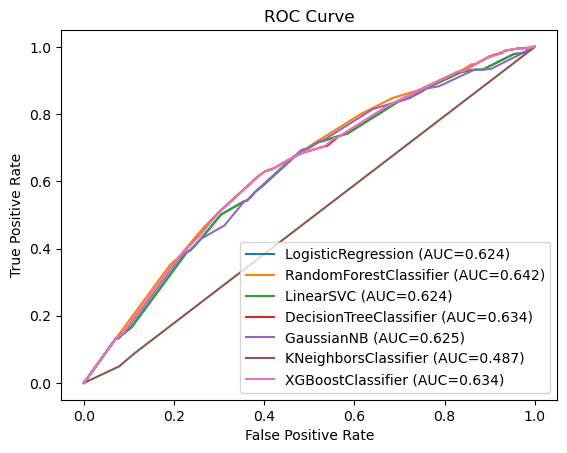

In [54]:
# Reassign datasets with selected features
X_binary_selected = X_binary3[selected_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_binary_selected, y_binary3, test_size=0.2, random_state=42
)
# Compute sample weights due to class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


for name, model in models.items():
    # Define parameter grid for GridSearchCV
    param_grid = {
        'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20, 30, 50]},
        'RandomForestClassifier': {'n_estimators': [5, 15, 25, 35, 45, 55, 75, 105], 'max_depth': [10, 20, 30, None]},
        'LinearSVC': {'C': [0.01, 0.1, 1, 10, 100]},
        'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
        'GaussianNB': {},  # No hyperparameters for GaussianNB
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGBoostClassifier': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    }

    # Adjust training data for specific models
    if name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    # GridSearchCV to find the best model
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='roc_auc')
    if  name in ['RandomForestClassifier', 'DecisionTreeClassifier', 'XGBoostClassifier']:
        grid_search.fit(X_train_model, y_train_model, sample_weight = sample_weights)
    else:
        grid_search.fit(X_train_model, y_train_model)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)

    # Print classification report
    print(f"\nModel: {name}")
    print(f"Best Parameters: {grid_search.best_params_ if param_grid[name] else 'Default Parameters'}")
    print(classification_report(y_test_model, y_pred))

    # Plot ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_model)[:, 1]
    else:  # For models like LinearSVC without predict_proba
        y_prob = best_model.decision_function(X_test_model)

    fpr, tpr, _ = roc_curve(y_test_model, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test_model, y_prob):.3f})')

# Show ROC plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### **Summary of Model Performances**

1. **Logistic Regression, LinearSVC, and GaussianNB**:
   - **Accuracy**: 94%
   - **Class Imbalance Impact**: These models predicted almost exclusively for the majority class (`0` - non-online shoppers), achieving high precision and recall for class `0` but failing completely for class `1`.

2. **RandomForestClassifier, DecisionTreeClassifier, and XGBoostClassifier**:
   - **Accuracy**: 60%
   - These models attempted to identify minority class (`1`) shoppers, but their overall performance suffered due to misclassification in the majority class.
   - **Macro Avg**: Around 0.53–0.61, slightly better due to improved recall for class `1` (63%).

3. **KNeighborsClassifier**:
   - **Accuracy**: 87%
   - **Class `1` Handling**: Limited ability to predict the minority class (`precision=0.04`, `recall=0.05`).
   - **Overall Performance**: A slightly balanced macro average (~0.49) compared to other models.


### **Insights Gained**

1. **Severe Class Imbalance**: The dataset is dominated by class `0` (non-online shoppers), making it challenging for the models to effectively predict the minority class `1`. This imbalance heavily skews performance metrics.

1. **Linear Models (Logistic Regression, LinearSVC, GaussianNB)**:  
   - These models excelled in predicting class `0`, but their inability to identify class `1` makes them unsuitable for practical use in this task.  

2. **Tree-Based Models (RandomForest, DecisionTree, XGBoost)**:  
   - These models show potential in identifying class `1`, much better than the linear models, due to their ability to handle non-linear relationships. However, they severely struggled with precision and recall trade-offs for both classes.  
   - XGBoost and Random Forest achieved the best balance between precision and recall for the minority class, albeit at a cost to overall accuracy.

3. **KNN Performance**:  
   - KNN was overly influenced by proximity-based predictions, performing poorly on the minority class while maintaining reasonable accuracy for the majority class.


### **Conclusions**

1. **Key Takeaways**:
   - The education and marital status provide limited predictive power for identifying online shoppers. We previously eliminated race as a feature in the feature selection process.
   - Severe class imbalance undermines the ability of all models to generalize effectively across both classes even after using SMOTE and class resampling.

2. **Best Models**:  
   - XGBoost, Random Forest, and Decision Tree demonstrated the highest potential for predicting class `1`. However, their moderate performance indicates a need for further refinement.


In conclusion, while the results show some promise for predicting online shoppers, the dataset’s imbalance and the limited explanatory power of the features significantly constrain model performance. More robust data preprocessing and feature engineering are necessary to make these predictions actionable.


---

## Multi-class Classification Section 

In this section, I will be employing 7 models for multi-class classification: Logistic Regression, Random Forest Classifier, Linear Support Vector Classification (LinearSVC), Decision Tree Classifier, Naive Bayes (GaussianNB), K Nearest Neighbors (KNN), and XGBoost (XGBoostClassifier). Please refer to the Binary Classification Section for an overview on each of these methods.

### Multi-class Classification Problem 1: Can we predict education level based on demographic, financial and shopping preference features?

In [55]:
# Research Question: Can we predict education level based on demographic and financial information?
ed_dict = {'no school completed': 0, 'grades 1-8': 1, 'high school no degree': 2, 'high school grad': 3, 'some college no degree': 4, 
           'associates degree': 5, 'bachelors degree': 6, 'graduate degree': 7}


# For Logistic Regression (Box-Cox-transformed data)

# Ensure consistent dropping of missing values
boxcox_multi_df = df[boxcox_combined_cols + target_cols]

# A little data cleaning to convert strings to numerical values
boxcox_multi_df['highest_ed_completed'] = boxcox_multi_df['highest_ed_completed'].replace(ed_dict)
boxcox_multi_df['income_category'] = boxcox_multi_df['income_category'].replace(income_dict)

# Drop rows with missing values 
boxcox_multi_df.dropna(inplace=True)

X_multi_boxcox = boxcox_multi_df.drop(columns='highest_ed_completed')
y_multi_boxcox = boxcox_multi_df['highest_ed_completed']

# Repeat the same process for the original data
multi_df = df[combined_cols + target_cols]
multi_df['highest_ed_completed'] = multi_df['highest_ed_completed'].replace(ed_dict)
multi_df['income_category'] = multi_df['income_category'].replace(income_dict)

multi_df.dropna(inplace=True)

X_multi = multi_df.drop(columns='highest_ed_completed')
y_multi = multi_df['highest_ed_completed']

# Feature Selection: Chi-square test for X_multi_boxcox and y_multi_boxcox (Logistic Regression)
print("\nChi-Square Test P-values for X_multi_boxcox:")
chi2_selector_boxcox = SelectKBest(chi2, k='all')
X_selected_boxcox = chi2_selector_boxcox.fit_transform(X_multi_boxcox, y_multi_boxcox)
p_values_boxcox = chi2_selector_boxcox.pvalues_

for feature, p_value in zip(X_multi_boxcox.columns, p_values_boxcox):
    print(f"{feature}: {p_value}")

selected_features_boxcox = [
    feature for feature, p_value in zip(X_multi_boxcox.columns, p_values_boxcox) if p_value < 0.05
]
print(f"Selected features after Chi-square test for X_multi_boxcox: {selected_features_boxcox}")

# Feature Selection: Chi-square test for X_multi and y_multi
print("Chi-Square Test P-values for X_multi:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected = chi2_selector.fit_transform(X_multi, y_multi)
p_values = chi2_selector.pvalues_

for feature, p_value in zip(X_multi.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_multi.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_multi: {selected_features}")



Chi-Square Test P-values for X_multi_boxcox:
boxcox_total_expense: 0.0
boxcox_online_expense: 2.0209536620579172e-21
boxcox_total_income: 0.0
age: 0.0
is_asian: 1.3766805986901974e-36
is_black: 1.4498345642079287e-20
race_unknown: 0.9446295181731386
is_native_american: 0.9725961589266824
is_other_race: 1.1237585099399939e-40
is_pacific_islander: 0.9936134056429544
is_white: 2.5531941370279145e-131
full_time_1_yr: 1.145862092779128e-202
part_time_1_yr: 3.7793388908528436e-10
full_time_part_yr: 3.2243818660442644e-42
part_time_part_yr: 3.618781232123814e-32
no_school_completed: 0.0
grades_1-8_completed: 0.0
high_school_no_degree: 0.0
high_school_grad: 0.0
some_college_no_degree: 0.0
associates_degree: 0.0
bachelors_degree: 0.0
graduate_degree: 0.0
is_married: 3.59626481074157e-207
is_widowed: 8.833651149626896e-28
is_divorced: 3.136971545511857e-34
is_separated: 1.6653422409496966e-15
is_single: 0.0
is_female: 2.525348500415976e-07
is_male: 3.3969905348901955e-08
income_category: 2.4859

/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/3814253671.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  boxcox_multi_df['highest_ed_completed'] = boxcox_multi_df['highest_ed_completed'].replace(ed_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/3814253671.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxcox_multi_df['highest_ed_completed'] = boxcox_multi_df['highest_ed_completed'].replace(ed_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/381

Selected features after Chi-square test for X_multi_boxcox: ['boxcox_total_expense', 'boxcox_online_expense', 'boxcox_total_income', 'age', 'is_asian', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'income_category', 'bought_online']

Selected features after Chi-square test for X_multi: ['total_expense', 'online_expense', 'total_income', 'is_asian', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'income_category', 'bought_online']

Model: LogisticRegression
Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       754
         3.0       1.00      1.00      1.00      1644
         4.0       1.00      1.00      1.00      1219
         5.0       1.00      1.00      1.00       632
         6.0       1.00      1.00      1.00      1377
         7.0       1.00      1.00      1.00       730

    accuracy                           1.00      6656
   macro avg       1.00      1.00      1.00      6656
weighted avg       1.00      1.00      1.00      6656



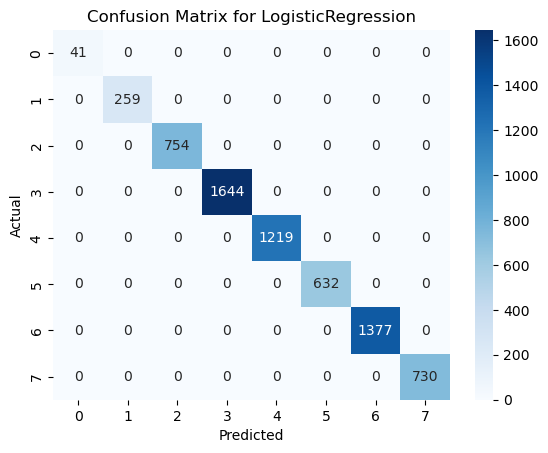

Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 5}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       754
         3.0       1.00      1.00      1.00      1644
         4.0       1.00      1.00      1.00      1219
         5.0       1.00      1.00      1.00       632
         6.0       1.00      1.00      1.00      1377
         7.0       1.00      1.00      1.00       730

    accuracy                           1.00      6656
   macro avg       1.00      1.00      1.00      6656
weighted avg       1.00      1.00      1.00      6656



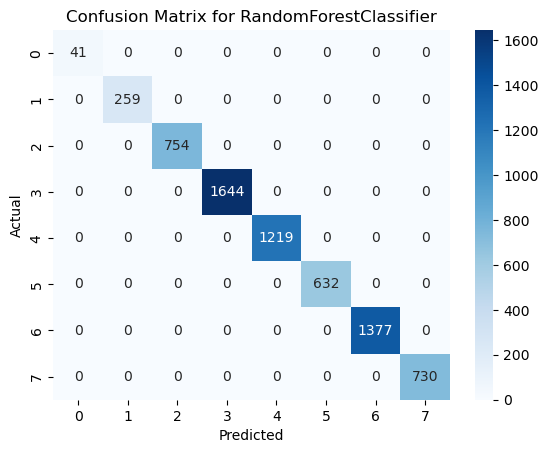

Model: LinearSVC
Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       754
         3.0       1.00      1.00      1.00      1644
         4.0       1.00      1.00      1.00      1219
         5.0       1.00      1.00      1.00       632
         6.0       1.00      1.00      1.00      1377
         7.0       1.00      1.00      1.00       730

    accuracy                           1.00      6656
   macro avg       1.00      1.00      1.00      6656
weighted avg       1.00      1.00      1.00      6656



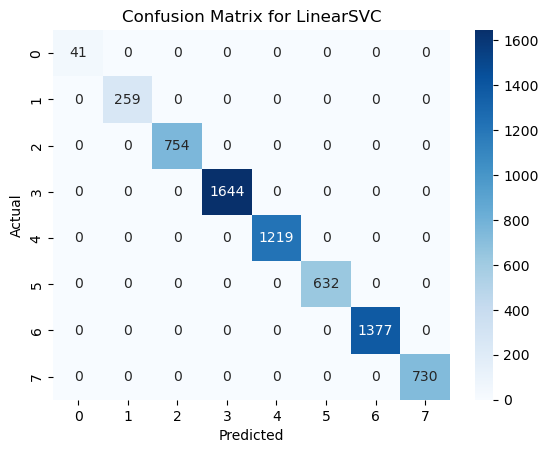

Model: DecisionTreeClassifier
Best Parameters: {'max_depth': 10, 'min_samples_split': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       754
         3.0       1.00      1.00      1.00      1644
         4.0       1.00      1.00      1.00      1219
         5.0       1.00      1.00      1.00       632
         6.0       1.00      1.00      1.00      1377
         7.0       1.00      1.00      1.00       730

    accuracy                           1.00      6656
   macro avg       1.00      1.00      1.00      6656
weighted avg       1.00      1.00      1.00      6656



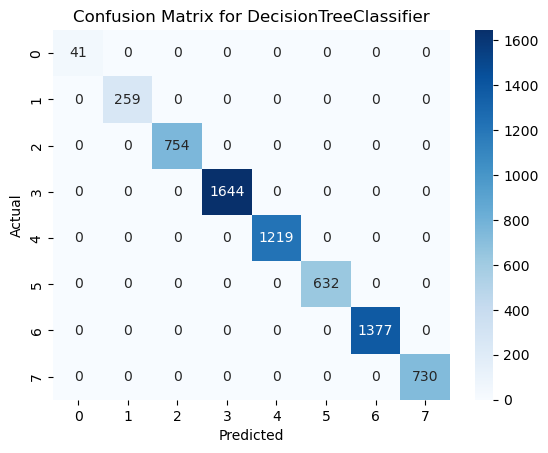

Model: GaussianNB
Best Parameters: {}
              precision    recall  f1-score   support

         0.0       0.02      0.10      0.04        41
         1.0       0.04      0.94      0.08       259
         2.0       0.00      0.00      0.00       754
         3.0       0.21      0.02      0.03      1644
         4.0       0.31      0.01      0.02      1219
         5.0       0.00      0.00      0.00       632
         6.0       0.37      0.10      0.16      1377
         7.0       0.33      0.02      0.04       730

    accuracy                           0.07      6656
   macro avg       0.16      0.15      0.05      6656
weighted avg       0.22      0.07      0.05      6656



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

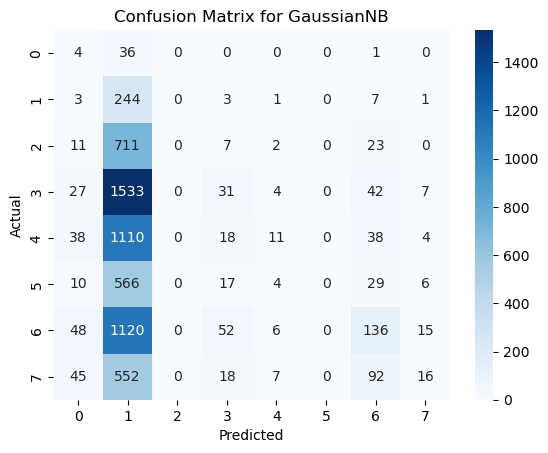

Model: KNeighborsClassifier
Best Parameters: {'n_neighbors': 9, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       754
         3.0       0.99      1.00      1.00      1644
         4.0       1.00      1.00      1.00      1219
         5.0       1.00      0.99      1.00       632
         6.0       1.00      1.00      1.00      1377
         7.0       1.00      0.99      0.99       730

    accuracy                           1.00      6656
   macro avg       1.00      1.00      1.00      6656
weighted avg       1.00      1.00      1.00      6656



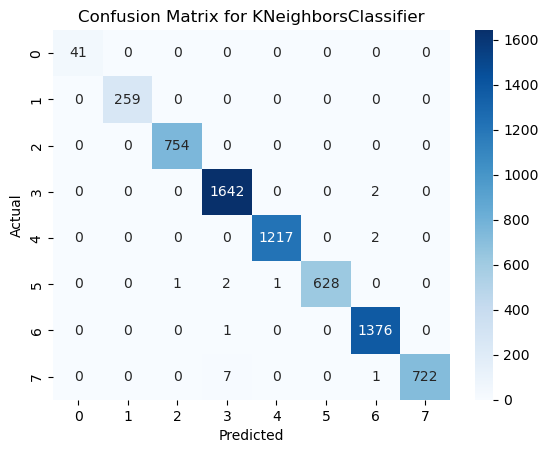

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:52:51] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:52:51] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:52:51] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho

Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       754
         3.0       1.00      1.00      1.00      1644
         4.0       1.00      1.00      1.00      1219
         5.0       1.00      1.00      1.00       632
         6.0       1.00      1.00      1.00      1377
         7.0       1.00      1.00      1.00       730

    accuracy                           1.00      6656
   macro avg       1.00      1.00      1.00      6656
weighted avg       1.00      1.00      1.00      6656



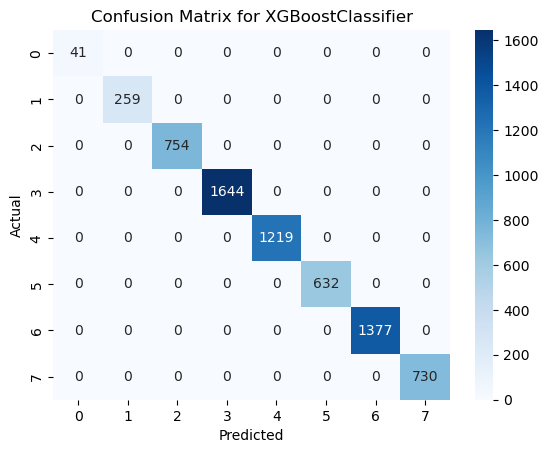

In [56]:
# Reassign X_binary with only selected features
X_multi_selected = X_multi[selected_features]
X_multi_boxcox_selected = X_multi_boxcox[selected_features_boxcox]

# Split the Box-Cox transformed data for Logistic Regression
X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(
    X_multi_boxcox_selected, y_multi_boxcox, test_size=0.2, random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_multi_selected, y_multi, test_size=0.2, random_state=42
)
# Compute sample weights due to class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Apply SMOTE for oversampling the minority class (only for Logistic Regression)
smote_boxcox = SMOTE(random_state=42)
X_train_resampled_boxcox, y_train_resampled_boxcox = smote_boxcox.fit_resample(X_train_boxcox, y_train_boxcox)

# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    param_grid = {
        'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20, 30, 50]},
        'RandomForestClassifier': {'n_estimators': [5, 15, 25, 35, 45, 55, 75, 105], 'max_depth': [10, 20, 30, None]},
        'LinearSVC': {'C': [0.01, 0.1, 1, 10, 100]},
        'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
        'GaussianNB': {},  # No hyperparameters for GaussianNB
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGBoostClassifier': {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150]}
    }

    # Adjust training data for specific models
    if name == 'LogisticRegression':
        X_train_model = X_train_resampled_boxcox
        y_train_model = y_train_resampled_boxcox
        X_test_model = X_test_boxcox
        y_test_model = y_test_boxcox
    elif name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='f1_macro')
    if  name in ['RandomForestClassifier', 'DecisionTreeClassifier', 'XGBoostClassifier']:
        grid_search.fit(X_train_model, y_train_model, sample_weight = sample_weights)
    else:
        grid_search.fit(X_train_model, y_train_model)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)

    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(classification_report(y_test_model, y_pred))

    
    cm = confusion_matrix(y_test_model, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### **Summary of Each Model's Performance**

1. **Logistic Regression, Random Forest Classifier, Linear SVC, Decision Tree Classifier and XGBoost Classifier**  
   - Achieved perfect scores (precision, recall, f1-score, accuracy = 1.00).
   - They handled the multi-class classification problem with no apparent errors in prediction.
   - They each seemed to effectively captured the decision boundaries in the dataset.

2. **Gaussian Naive Bayes**  
   - Poorest results (accuracy = 0.07), the randomness assumption may be the cause for its poor pricision and recall across all 8 classes.

3. **K-Nearest Neighbors (KNN)**  
   - High accuracy (= 1) with precision and recall nearing perfect for all classes.  

### **Interpretation of Results**

- **Perfect results in multiple models**: Logistic Regression, Random Forest, Linear SVC Decision Tree, and XGBoost achieved flawless classification results, implying the data features are highly predictive of education level.  KNN was almost there with its performance.
- **Gaussian NB:** Its poor accuracy is a strong indication that it is not suitable for this task. GNB assumes that features are conditionally independent given the class label. This assumption is often violated in real-world data so this model is not the best option.


### **Insights Gained**
1. **Predictive power of demographic and financial features**: The perfect scores suggest these features are highly indicative of education level. Features like income, and employment type likely contribute significantly to the classification.
2. **Impactful Factors:** total income, total expense, online expenses, race, earning type, sex, and marital status all play a role in determining a person's education attainment.
3. **Effectiveness of ensemble methods**: Random Forest and XGBoost outperformed in handling complexities and potential noise in the data, proving their utility for structured datasets.
4. **Class imbalance impact**: Linear SVC and KNN showed slight performance degradation on minority class predictions, emphasizing the need for balancing techniques.

### **Recommendation**
- Implement XGBoost as it offers the best balance of robustness and adaptability for this task. Random Forest and Decision Tree are simpler but just as effective alternatives that offer easy interpretability, crucial for explaining to non-technical audiences. 

---

### Multi-class Classifcation Problem 2: Can we predict income level based on demographic, financial information, shopping preference?

In [42]:
# Research Question: Can we predict income level based on demographic, financial information, shopping preference?
income_dict = {'Low': 0, 'Middle': 1, 'High': 2}
# For Logistic Regression (Box-Cox-transformed data)

boxcox_multi_df_2 = df[boxcox_combined_cols]
# A little data cleaning to convert strings to numerical values
boxcox_multi_df_2['income_category'] = boxcox_multi_df_2['income_category'].replace(income_dict)

# Drop rows with missing values 
boxcox_multi_df_2.dropna(inplace=True)

X_multi_boxcox_2 = boxcox_multi_df_2.drop(columns='income_category')
y_multi_boxcox_2 = boxcox_multi_df_2["income_category"]

# Repeat the same process for the original data
multi_df_2 = df[combined_cols]
multi_df_2['income_category'] = multi_df_2['income_category'].replace(income_dict)

# Drop rows with missing values 
multi_df_2.dropna(inplace=True)
X_multi_2 = multi_df_2.drop(columns='income_category')
y_multi_2 = multi_df_2["income_category"]

# Feature Selection: Chi-square test for X_multi_boxcox and y_multi_boxcox (Logistic Regression)
print("\nChi-Square Test P-values for X_multi_boxcox:")
chi2_selector_boxcox = SelectKBest(chi2, k='all')
X_selected_boxcox_2 = chi2_selector_boxcox.fit_transform(X_multi_boxcox_2, y_multi_boxcox_2)
p_values_boxcox_2 = chi2_selector_boxcox.pvalues_

for feature, p_value in zip(X_multi_boxcox_2.columns, p_values_boxcox_2):
    print(f"{feature}: {p_value}")

selected_features_boxcox = [
    feature for feature, p_value in zip(X_multi_boxcox_2.columns, p_values_boxcox_2) if p_value < 0.05
]
print(f"Selected features after Chi-square test for X_multi_boxcox_2: {selected_features_boxcox}")

# Feature Selection: Chi-square test for X_multi and y_multi
print("Chi-Square Test P-values for X_multi:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected_2 = chi2_selector.fit_transform(X_multi_2, y_multi_2)
p_values_2 = chi2_selector.pvalues_

for feature, p_value in zip(X_multi_2.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_multi_2.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_multi_2: {selected_features}")



Chi-Square Test P-values for X_multi_boxcox:
boxcox_total_expense: 0.0
boxcox_online_expense: 2.0036615962981398e-26
boxcox_total_income: 0.0
age: 1.7940360012777778e-131
is_asian: 5.02381203448084e-13
is_black: 5.09484711283143e-78
race_unknown: 0.2941928061468539
is_native_american: 0.827415189397762
is_other_race: 1.603306173226065e-10
is_pacific_islander: 0.9801488118286863
is_white: 8.616387980885378e-244
full_time_1_yr: 5.405000728295143e-155
part_time_1_yr: 0.013984486368245145
full_time_part_yr: 0.06747165166934138
part_time_part_yr: 1.1734300143444002e-14
no_school_completed: 2.4458671882525955e-10
grades_1-8_completed: 1.2077908309393609e-17
high_school_no_degree: 1.1705901062864172e-53
high_school_grad: 1.3832162720317053e-75
some_college_no_degree: 3.8527412006978675e-09
associates_degree: 0.043190916746284974
bachelors_degree: 5.073978172390734e-112
graduate_degree: 8.021424651047977e-131
is_married: 1.0945032968138317e-256
is_widowed: 3.7176251148424597e-90
is_divorced: 

/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/2228461966.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  boxcox_multi_df_2['income_category'] = boxcox_multi_df_2['income_category'].replace(income_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/2228461966.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxcox_multi_df_2['income_category'] = boxcox_multi_df_2['income_category'].replace(income_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_83299/222846196

Selected features after Chi-square test for X_multi_boxcox_2: ['boxcox_total_expense', 'boxcox_online_expense', 'boxcox_total_income', 'age', 'is_asian', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'part_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'bought_online']


Selected features after Chi-square test for X_multi_2: ['total_expense', 'online_expense', 'total_income', 'is_asian', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'bought_online']

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Model: LogisticRegression
Best Parameters: {'C': 20, 'max_iter': 50000}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1368
           1       0.97      0.98      0.97      2272
           2       1.00      0.98      0.99      4212

    accuracy                           0.98      7852
   macro avg       0.98      0.99      0.98      7852
weighted avg       0.99      0.98      0.99      7852



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


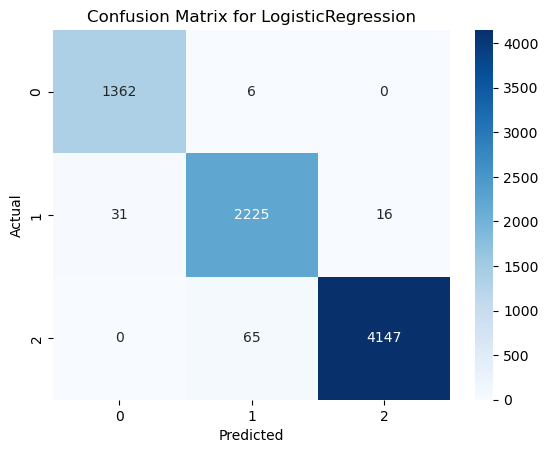

Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 35}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1368
           1       1.00      1.00      1.00      2272
           2       1.00      1.00      1.00      4212

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



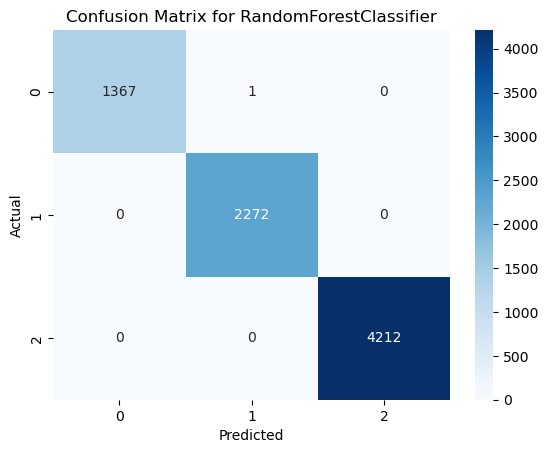

Model: LinearSVC
Best Parameters: {'C': 1, 'max_iter': 50000}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1368
           1       1.00      0.97      0.98      2272
           2       0.99      1.00      0.99      4212

    accuracy                           0.99      7852
   macro avg       0.99      0.99      0.99      7852
weighted avg       0.99      0.99      0.99      7852



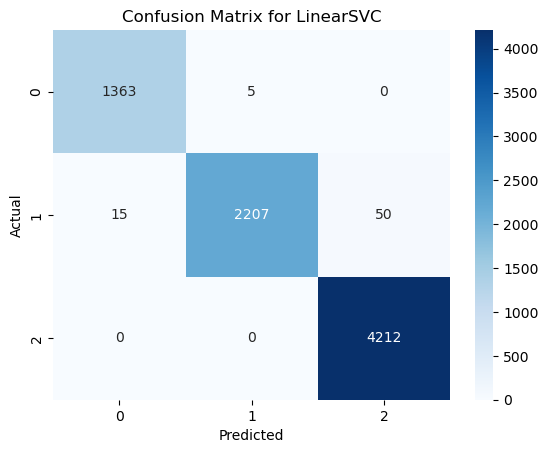

Model: DecisionTreeClassifier
Best Parameters: {'max_depth': 5, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1368
           1       1.00      1.00      1.00      2272
           2       1.00      1.00      1.00      4212

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



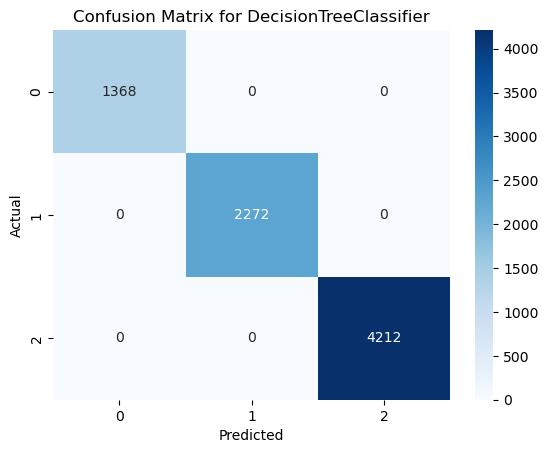

Model: GaussianNB
Best Parameters: {}
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1368
           1       0.85      0.98      0.91      2272
           2       0.98      0.93      0.96      4212

    accuracy                           0.94      7852
   macro avg       0.95      0.95      0.94      7852
weighted avg       0.95      0.94      0.94      7852



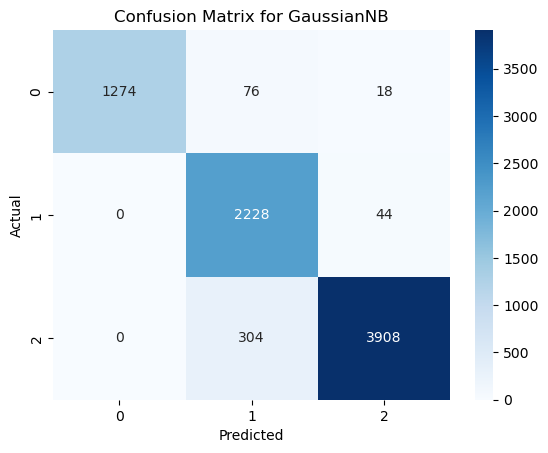

Model: KNeighborsClassifier
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1368
           1       0.86      0.86      0.86      2272
           2       0.95      0.96      0.95      4212

    accuracy                           0.91      7852
   macro avg       0.90      0.89      0.90      7852
weighted avg       0.91      0.91      0.91      7852



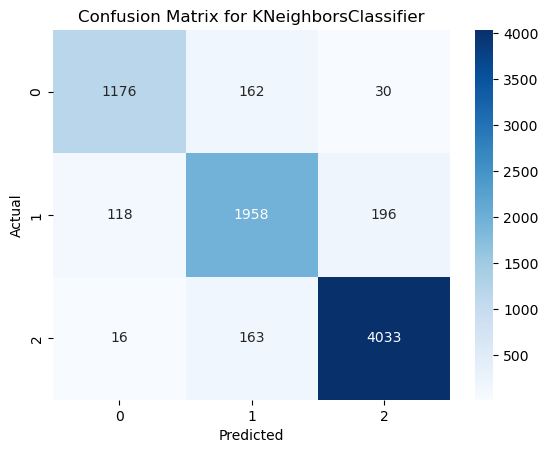

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:00:14] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:00:15] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:00:15] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho

Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1368
           1       1.00      1.00      1.00      2272
           2       1.00      1.00      1.00      4212

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



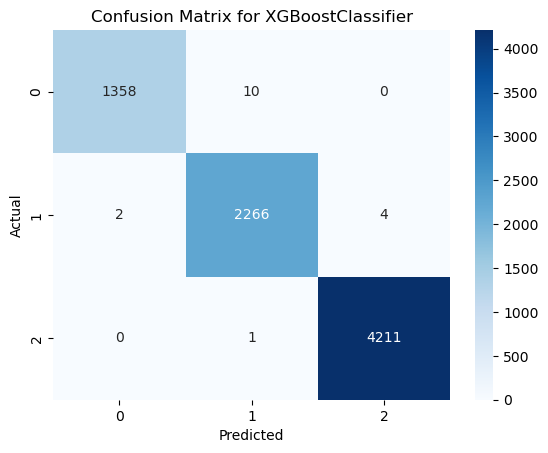

In [43]:
# Reassign X_binary with only selected features
X_multi_selected_2 = X_multi_2[selected_features]
X_multi_boxcox_selected_2 = X_multi_boxcox_2[selected_features_boxcox]

# Split the Box-Cox transformed data for Logistic Regression
X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(
    X_multi_selected_2, y_multi_boxcox_2, test_size=0.2, random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_multi_selected_2, y_multi_2, test_size=0.2, random_state=42
)

# Compute sample weights due to class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Apply SMOTE for oversampling the minority class (only for Logistic Regression)
smote_boxcox = SMOTE(random_state=42)
X_train_resampled_boxcox, y_train_resampled_boxcox = smote_boxcox.fit_resample(X_train_boxcox, y_train_boxcox)

# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    
    param_grid = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20], 'max_iter': [50000, 100000]},
    'RandomForestClassifier': {'n_estimators': [15, 35, 55], 'max_depth': [10, 20, 30, None]},
    'LinearSVC': {'C': [0.01, 0.1, 1], 'max_iter': [50000, 100000]},
    'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5]},
    'GaussianNB': {},  # No hyperparameters for GaussianNB
    'KNeighborsClassifier': {'n_neighbors': [5, 7, 9], 'weights': ['uniform', 'distance']},
    'XGBoostClassifier': {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'n_estimators': [100, 150]
        }
    }


    # Adjust training data for specific models
    if name == 'LogisticRegression':
        X_train_model = X_train_resampled_boxcox
        y_train_model = y_train_resampled_boxcox
        X_test_model = X_test_boxcox
        y_test_model = y_test_boxcox
    elif name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='f1_macro')
    if  name in ['RandomForestClassifier', 'DecisionTreeClassifier', 'XGBoostClassifier']:
        grid_search.fit(X_train_model, y_train_model, sample_weight = sample_weights)
    else:
        grid_search.fit(X_train_model, y_train_model)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)

    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(classification_report(y_test_model, y_pred))

    
    cm = confusion_matrix(y_test_model, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### **Summary of Each Model's Performance**

1. **Random Forest Classifier, Decision Tree Classifier and XGBoost Classifier**  
   - Achieved perfect scores (precision, recall, f1-score, accuracy = 1.00).
   - They handled the multi-class classification problem with no apparent errors in prediction.
   - They each seemed to effectively captured the decision boundaries in the dataset.

2. **Logistic Regression, LinearSVC, Gaussian Naive Bayes, K Nearest Neighbors**  
   - All had high accuracy levels (at least 90%)

### **Interpretation of Results**

- **Perfect results in multiple models**: Random Forest, Decision Tree and XGBoost achieved excellent classification results, implying the data features are highly predictive of income level.


### **Insights Gained**
1. **Predictive power of demographic, financial, and online shopping preference features**: The high accuracy scores suggest these features are highly indicative of income level. 
2. **Effectiveness of ensemble methods**: Random Forest and XGBoost outperformed in handling complexities and potential noise in the data, proving their utility for structured datasets.
3. **Class imbalance impact**: KNN showed slight performance degradation on minority class predictions.

### **Recommendation**
- Implement XGBoost as it offers the best balance of robustness and adaptability for this task. Random Forest and Decision Tree are simpler but just as effective alternatives that offer easy interpretability, crucial for explaining to non-technical audiences. 

---

## Final Takeaways from each task

- We can effectively address our research question, "Can we predict one's online shopping expenditure based on their annual earnings and expenses?", using a Decision Tree Regressor with total expenses and income from a calendar year.
- We can best predict whether one's online shopped based on demographic and financial variables with XGBoost as offers the best combination of robustness, flexibility and generalizability. Logistic Regression, Random Forest and Decision Tree are all excellent choices, too. 
- No ML model we ran exhibits a strong ability to classify the sex of the individuals on our data based on the provided demographic, financial, and online shopping preference information.
- No ML model we ran exhibits a strong ability to identify online shoppers in on our data based on their education and marital status.
- We can  predict an individual's education level based on demographic, financial and shopping preference features, using XGBoost as the best model.
  - As we had identified in EDA that more educated individuals are most likely to shop online, we can use predictive modeling to find highly educated individuals to receive marketing efforts to increase their participation in online shopping.
- We can predict an individual's income level based on demographic, financial and shopping preference features, using XGBoost as the best model.
  - Since we found out in the EDA stage that online shoppers are typically earn higher incomes, we can use predictive modeling to find more affluent individuals to receive marketing efforts to increase their participation in online shopping.